<a href="https://colab.research.google.com/github/Marvin2798/CNN-Project-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Link : https://github.com/ironhack-labs/project-1-deep-learning-image-classification-with-cnn/blob/main/README.md#project-i--deep-learning-image-classification-with-cnn

Loading and Data Processing

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#loading the dataset since we can access it through keras
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
#normalise the pixel values to 0 and 1 by dividing by 255
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train
X_test


array([[[[0.61960787, 0.4392157 , 0.19215687],
         [0.62352943, 0.43529412, 0.18431373],
         [0.64705884, 0.45490196, 0.2       ],
         ...,
         [0.5372549 , 0.37254903, 0.14117648],
         [0.49411765, 0.35686275, 0.14117648],
         [0.45490196, 0.33333334, 0.12941177]],

        [[0.59607846, 0.4392157 , 0.2       ],
         [0.5921569 , 0.43137255, 0.15686275],
         [0.62352943, 0.44705883, 0.1764706 ],
         ...,
         [0.53333336, 0.37254903, 0.12156863],
         [0.49019608, 0.35686275, 0.1254902 ],
         [0.46666667, 0.34509805, 0.13333334]],

        [[0.5921569 , 0.43137255, 0.18431373],
         [0.5921569 , 0.42745098, 0.12941177],
         [0.61960787, 0.43529412, 0.14117648],
         ...,
         [0.54509807, 0.38431373, 0.13333334],
         [0.50980395, 0.37254903, 0.13333334],
         [0.47058824, 0.34901962, 0.12941177]],

        ...,

        [[0.26666668, 0.4862745 , 0.69411767],
         [0.16470589, 0.39215687, 0.5803922 ]

In [5]:
#datagenÍmage


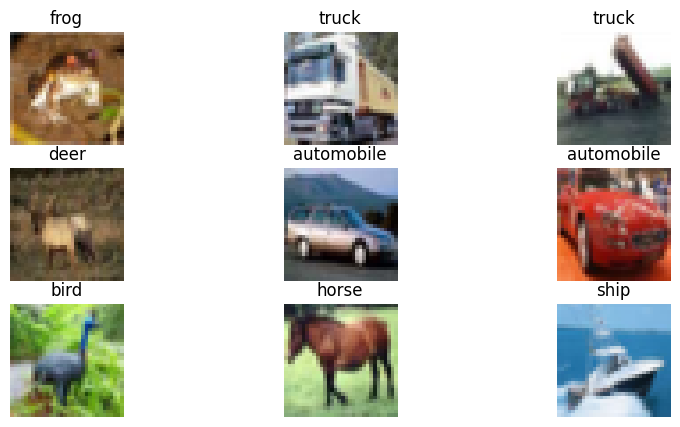

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.show()

Model Architecture

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential()

# Add convolutional layers and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add fully connected (dense) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to avoid overfitting
model.add(Dense(10, activation='softmax'))  # Output layer (10 classes)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [9]:
# Display the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)